## Making sure Metropolis-Hastings works

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

In [190]:
def energy(sequence, J):
    """
    Calculate the Hamiltonian of the sequence.
    Args:
        sequence (np.array): The current sequence of spins.
        J (np.array): Interaction matrix.
    Returns:
        float: The energy of the current sequence.
    """
    return -np.sum(J * np.outer(sequence, sequence))

def set_interaction_mat(size, prob=[0.5,0.5]):
    J = np.random.choice([0,1],(size,size),p=prob) # interaction matrix
    J = J.T + J
    J[J==2] = 1
    J[J==-2] = -1
    return J

In [234]:
def propose_sequence(current_sequence, num_of_flips=1, prob=0.5):
    """
    Propose a new sequence by flipping a set number of spins.
    Args:
        current_sequence (np.array): The current sequence of spins.
        num_of_flips (int): Number of spins to flip.
    Returns:
        np.array: The proposed sequence of spins.
    """
    new_sequence = current_sequence.copy()
    flip_indices = np.random.choice(len(new_sequence), num_of_flips, replace=False)
    #flip_decisions = np.random.uniform(0, 1, size=num_of_flips) < prob
    #new_sequence[flip_indices] = -new_sequence[flip_indices]
    new_sequence[flip_indices] *= -1
    return new_sequence
'''
def propose_sequence(x, num_of_flips, prob):
    """
    Function:
        Flip one of the spins in the sequence at random
    Args:
        x: sequence of spins 
    """
    # Determine the indices to consider for flipping
    indices = np.random.choice(len(x), num_of_flips)
    # Generate random numbers for each chosen index to decide if a flip should occur
    flip_decisions = np.random.uniform(0, 1, size=num_of_flips) < prob
    # Apply flips where decided
    x[indices[flip_decisions]] *= -1
    return x
'''
def identify_and_flip_clusters(current_sequence, J, T):
    """
    Identify clusters based on J and propose a new sequence by flipping one of these clusters.
    Args:
        current_sequence (np.array): The current sequence of spins.
        J (np.array): Interaction matrix providing lattice and neighborhood information.
        T (float): Temperature, influencing the probability of flipping a cluster.
    Returns:
        np.array: The proposed sequence of spins after possibly flipping a cluster.
    """
    new_sequence = current_sequence.copy()
    size = len(current_sequence)
    # Randomly choose a starting point for the cluster
    start_index = np.random.randint(size)
    cluster = [start_index]
    for i in cluster:
        for j in range(size):
            # If spins are interacting strongly and not yet in the cluster, add them
            if J[i, j] > 0 and j not in cluster and current_sequence[i] == current_sequence[j]:
                # Add to the cluster based on a probability related to the interaction strength and temperature
                if np.random.rand() < np.exp(J[i, j] / T):
                    cluster.append(j)
    
    # Flip the entire cluster with some probability (could be based on size, energy, etc.)
    if np.random.rand() < 0.5:  # Example probability, adjust as needed
        for i in cluster:
            new_sequence[i] = -new_sequence[i]
    
    return new_sequence

def metropolis_hastings(J, initial_sequences, num_iters, T=1.0, num_of_flips=1):
    """
    Perform the Metropolis-Hastings algorithm on multiple sequences.
    Args:
        J (np.array): Interaction matrix.
        initial_sequences (list of np.array): Initial sequences of spins.
        num_iterations (int): Number of iterations to perform.
        T (float): Temperature.
        num_of_flips (int): Number of spins to flip in each proposal.
    Returns:
        list of np.array: Final sequences after iterations.
    """
    current_sequences = initial_sequences.copy()
    log_sequences = np.zeros((len(current_sequences), num_iters))
    updated_log_sequences = []
    accepted_states = np.zeros(len(current_sequences))
    for n in range(num_iters):
        for i in range(len(current_sequences)):
            proposed_sequence = propose_sequence(current_sequences[i], num_of_flips)
            current_energy = energy(current_sequences[i], J)
            proposed_energy = energy(proposed_sequence, J)
            energy_difference = proposed_energy - current_energy
            if (energy_difference < 0):
                current_sequences[i] = proposed_sequence
                accepted_states[i]+=1

            else:
                if np.random.uniform(0,1)<np.exp(-energy_difference/T):
                    current_sequences[i] = proposed_sequence
                    #log_sequences[:,accepted_states[i]] = np.absolute(np.sum(np.array(current_sequences), axis=1))
                    accepted_states[i]+=1
        log_sequences[:,n] = np.absolute(np.sum(np.array(current_sequences), axis=1)/len(current_sequences[0]))

    #for i in range(len(current_sequences)):
    #    updated_log_sequences.append(np.unique(log_sequences[i,:]))
    return current_sequences, log_sequences, accepted_states

# Example usage:
np.random.seed(42)  # For reproducibility

size = 200  # Size of each sequence
num_sequences = 400  # Number of sequences
J = set_interaction_mat(size) # Example interaction matrix, should be symmetric
initial_sequences = [np.random.choice([-1, 1], size=size) for _ in range(num_sequences)]

final_sequences, log_sequences, accepted_states = metropolis_hastings(J, initial_sequences, num_iters=1000, T=5.0, num_of_flips=10)
# Final_sequences contains the sequences after they have potentially reached their stable states


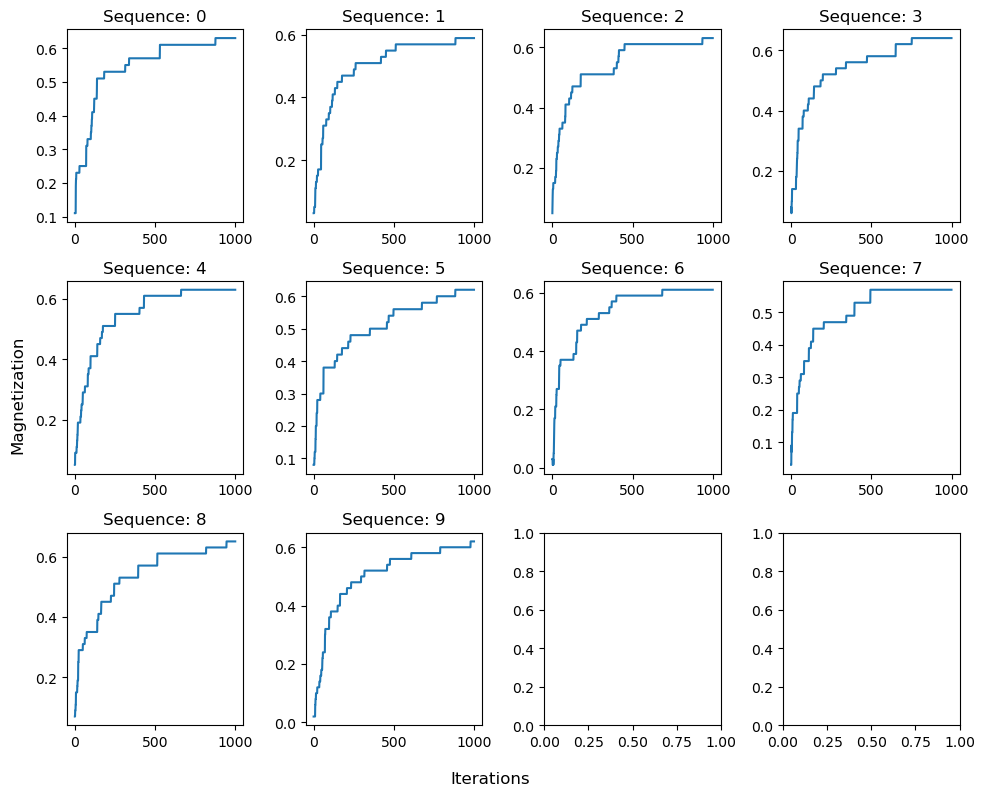

[38. 41. 33. 39. 44. 40. 44. 41. 43. 54. 40. 29. 40. 44. 27. 38. 46. 36.
 51. 47. 47. 46. 43. 35. 33. 47. 47. 47. 41. 45. 42. 38. 30. 52. 44. 42.
 39. 41. 46. 36. 32. 35. 34. 40. 42. 36. 35. 40. 38. 44. 31. 51. 46. 46.
 42. 51. 46. 30. 47. 44. 45. 44. 41. 44. 44. 31. 41. 30. 41. 43. 43. 36.
 36. 44. 44. 49. 40. 58. 33. 40. 40. 38. 37. 27. 40. 42. 37. 40. 33. 37.
 38. 46. 33. 41. 47. 37. 45. 33. 39. 39. 47. 49. 48. 42. 43. 45. 42. 40.
 44. 42. 36. 43. 38. 51. 43. 44. 47. 47. 47. 48. 36. 38. 47. 40. 43. 40.
 42. 46. 44. 42. 43. 48. 44. 35. 43. 31. 42. 30. 42. 42. 38. 38. 46. 40.
 38. 41. 34. 33. 38. 39. 43. 39. 40. 43. 42. 45. 38. 53. 41. 34. 41. 43.
 29. 42. 34. 53. 43. 39. 45. 35. 37. 30. 45. 52. 42. 47. 33. 47. 38. 38.
 45. 41. 46. 39. 43. 45. 38. 39. 41. 35. 51. 41. 47. 33. 42. 42. 40. 42.
 34. 37. 43. 46. 39. 45. 27. 38. 38. 37. 39. 38. 47. 38. 42. 46. 43. 39.
 38. 32. 33. 37. 47. 42. 33. 33. 42. 41. 43. 50. 40. 37. 47. 38. 41. 54.
 39. 39. 38. 39. 43. 45. 36. 49. 56. 48. 40. 48. 38

In [235]:
def plotting_magnetization(log_sequences):
    fig, ax = plt.subplots(3, 4, figsize=(10,8))
    k = 0
    for i in range(3):
        for j in range(4):
            ax[i,j].plot(np.arange(1000), log_sequences[k])
            ax[i,j].set_title("Sequence: "+str(k))
            k +=1
            if k == 10:
                break
    fig.supxlabel("Iterations")
    fig.supylabel("Magnetization")
    plt.tight_layout()
    plt.show()
plotting_magnetization(log_sequences)
print(accepted_states)
print(log_sequences)


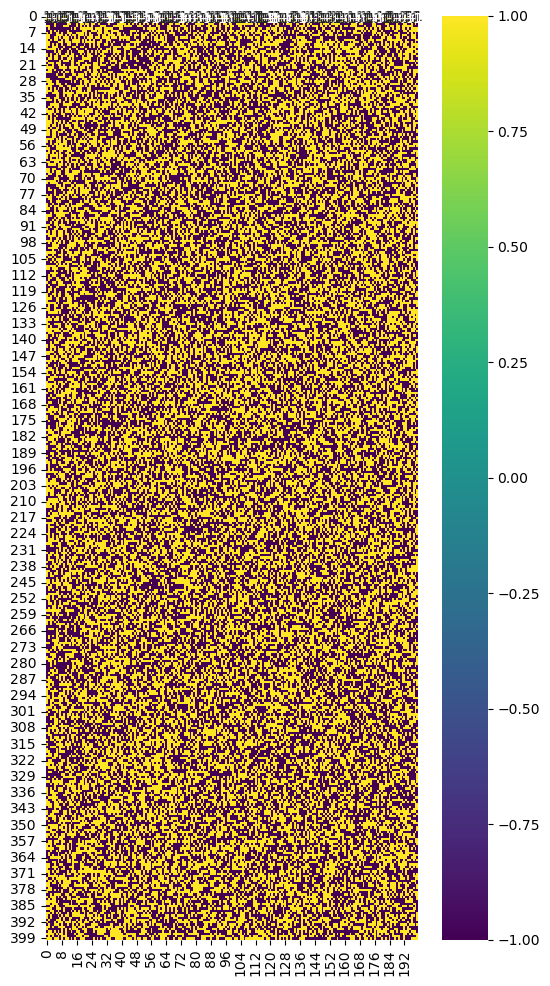

In [165]:
plt.figure(figsize=(6,12))
sns.heatmap(np.array(initial_sequences), cmap='viridis', annot=True)
plt.show()

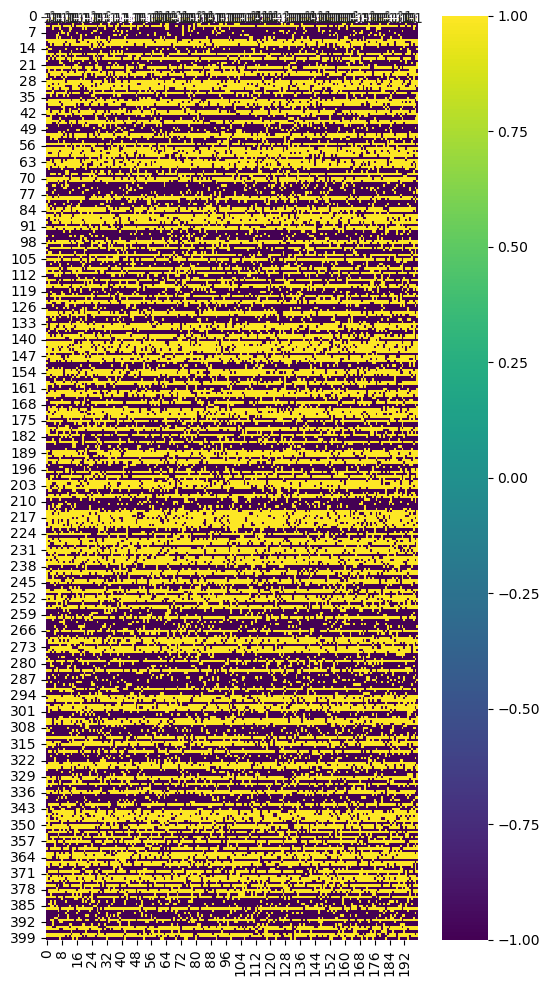

In [166]:
plt.figure(figsize=(6,12))
sns.heatmap(np.array(final_sequences), cmap='viridis', annot=True)
plt.show()

In [167]:
final_chains = np.array(final_sequences)
initial_chains = np.array(initial_sequences)
print("Number of chains:",final_chains.shape[0])
print("Number of spins in the chain:",final_chains.shape[1])

Number of chains: 400
Number of spins in the chain: 200


## Calculating TP fraction
1. Calculate covariance (or correlation matrix) (imported from the authors implementation)
2. Calculate frequencies

In [266]:
def ComputeCorrelationMatrix2(mat, pseudocount):
    
    nbr_spins = len(mat[0,:])
    nbr_chains = len(mat[:,0])
    mat = np.array(mat,ndmin = 2, dtype = np.float64)
    average_spin = np.average(mat, axis = 0)[:,None]
    
    directcorr = np.dot(mat.T, mat)
    
    directcorr *= np.true_divide(1, nbr_chains, dtype = np.float64)
    
    correlation_matrix = np.dot(1.0-pseudocount, directcorr) - np.dot(pow(1-pseudocount,2),np.outer(average_spin.T, average_spin)) + np.dot(pseudocount,np.identity(nbr_spins))
    
    return correlation_matrix

corr_mat = ComputeCorrelationMatrix2(final_chains, 0.5)
#corr_mat

In [267]:
def calc_frequency(mat,pseudocount):
    f = np.zeros((mat.shape[1]))
    for i in range(len(f)):
        f[i] = (1-pseudocount)*np.sum(mat[:,i] == 1)/mat.shape[0] + pseudocount/mat.shape[1]
    return f

def coupled_frequency(mat,pseudocount):
    f_coupled = np.ones((mat.shape[1], mat.shape[1]))
    for i in range(mat.shape[1]):
        for j in range(i+1, mat.shape[1]):
            one_to_one = 0
            for k in range(mat.shape[0]):
                # both are have 1 and 1 spins
                if mat[k,i] == mat[k,j]:
                    one_to_one += 1
            f_coupled[i,j] = (1-pseudocount)*one_to_one/mat.shape[0] + pseudocount/(2*mat.shape[1])
    f_coupled = (f_coupled.T + f_coupled)/2
    return f_coupled
            
#print("Individual frequency for occurence of 1:",calc_frequency(final_chains, 0.5))
#print("Coupled frequency:",coupled_frequency(initial_chains, 0.5)[0])

In [268]:
def MI(f_coupled, f_ind):
    MI_calc = np.zeros((mat.shape[1], mat.shape[1]))
    for i in range(mat.shape[1]):
        for j in range(i+1, mat.shape[1]):
            #print("Coupled frequency: ",f_coupled[i,j])
            #print("Individual frequency i: ",f_ind[i])
            #print("Individual frequency j: ",f_ind[j])
            #MI_calc[i,j] = -entropy(f_coupled[i,j]) + entropy(f_ind[i]) + entropy(f_ind[j]) #np.log(f_coupled[i,j]/(f_ind[i]*f_ind[j]))
            MI_calc[i,j] = entropy(pk=f_coupled[i,j], qk=f_ind[i]*f_ind[j])
            MI_calc[i,j] = f_coupled[i,j]*np.log(f_coupled[i,j]/(f_ind[i]*f_ind[j]))
    return MI_calc

MI_mat = MI(coupled_frequency(initial_chains, 0.5), calc_frequency(final_chains, 0.5))

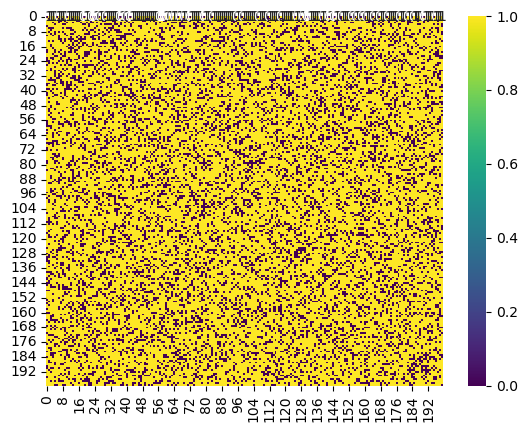

In [269]:
'''
MI_mat = (MI_mat.T+MI_mat)/2
J_estimated = np.linalg.inv(MI_mat)
print(abs(J_estimated)[0][1:].mean())
'''
J_estimated_C = np.linalg.inv(corr_mat)
#print(np.abs(J_estimated_C))

plt.figure()
sns.heatmap(np.array(J), cmap='viridis', annot=True)
plt.show()


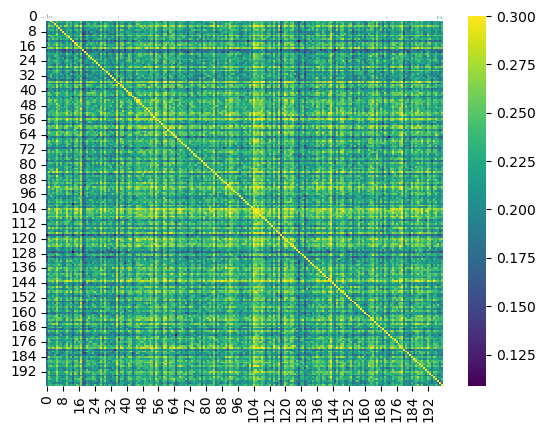

In [270]:
plt.figure()
sns.heatmap(np.array(corr_mat), vmax = 0.3, cmap='viridis', annot=True)
plt.show()

In [271]:
corr_mat_copy = corr_mat.copy()
corr_mat[np.round(corr_mat,2)==1] = 0
corr_mat_copy[corr_mat<np.mean(corr_mat)] = 0
corr_mat_copy[corr_mat>np.mean(corr_mat)] = 1


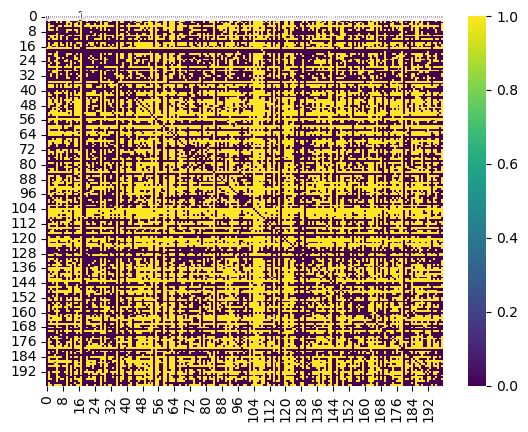

In [272]:
plt.figure()
sns.heatmap(np.array(corr_mat_copy), cmap='viridis', annot=True)
plt.show()

## Questions:
1. Do we have to consider different types of frequencies (e.g. of -1 and 1 being together or 1 and 1 being separate from -1 and -1)? **Yes, needs to be corrected**
2. Why is it necessary to use histograms of MSA? Can we just use the values for frequencies? **Any distribution or function will do**
3. How do you infer J from MI? **Take the inverse and normalise or normlaise and take the inverse**
4. Plot in terms of accepted steps


> mfDCA - on simulated data

> PlmDCA - on real data (on simulated data it is overkill in terms of computing power)


## Actions:
1. Change frequency function to the correct one (-)
2. Plot the magnetization per accepted steps (-)
3. Implement or import the mfDCA function (+)
4. Adapt it for different sampling temperature (-)


In [273]:
# imported from the supplementary code
def Inference_MF(mat_corr, matrix_contacts,bl_abs,bl_apc):
    """
    Infer the contacts using MF approximation
    """
    val,cts = np.unique(matrix_contacts,return_counts = True)
    nbrcontacts = cts[val == 1]
    flag = True
    # inverse of the correlation matrix to get the couplings
    
    try:
        inferred_couplings = np.linalg.inv(mat_corr)
    except:
        flag = False
        
    if flag:
        if bl_abs:
            inferred_couplings = np.abs(inferred_couplings)
            
        if bl_apc:
            np.fill_diagonal(inferred_couplings,0)
            S = inferred_couplings.copy()
            inferred_couplings -= (np.mean(S, axis=1, keepdims=True) * np.mean(S, axis=0, keepdims=True)) / np.mean(S)
    
        
        
        TP = []
    
        # order the 2d array and find the index of the sorted values in the matrix
        if bl_abs:
            index_sorted_array_x, index_sorted_array_y  = np.unravel_index(np.argsort(-inferred_couplings, axis=None), inferred_couplings.shape)
        else:
            index_sorted_array_x, index_sorted_array_y  = np.unravel_index(np.argsort(inferred_couplings, axis=None), inferred_couplings.shape)
    
    
        idx_flip = list(index_sorted_array_x)
        idy_flip = list(index_sorted_array_y)
    
        # indirect_corr_second_order =[]
    
        FP = []
    
        TP_coords = []
        all_coords = []
        N = 0 
        number_pairs = []
    
        list_tp = []
        TP = 0
    
        list_tp_fraction_allpairs = []
    
    
        for x, y in zip(idx_flip, idy_flip):
    
            # just look at the elements above the diagonal as symmetric matrix
            # to not count twice each contact
            if y > x:
    
                N = N + 1
    
                number_pairs.append(N)

    
                if matrix_contacts[x,y] == 1:
                    TP = TP + 1
                    if N <= nbrcontacts:
                        TP_coords.append([x,y])
                else:
    
                    if N <= nbrcontacts:
                        FP.append([x,y])

    
                list_tp.append(TP)
    
                all_coords.append([x,y])
    
                list_tp_fraction_allpairs.append(TP/N)
    
        return list_tp_fraction_allpairs, FP
    
    else:
        mat = np.zeros(nbrcontacts)
        mat[:] = np.nan
        return mat,mat


In [274]:
list_tp_fraction_allpairs, FP = Inference_MF(corr_mat, J,bl_abs=True,bl_apc=False)

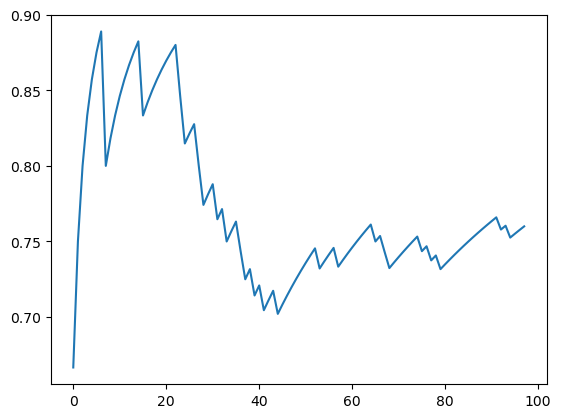

In [263]:
plt.plot(list_tp_fraction_allpairs[2:100])